Index Investing vs Active Investing <br>
Copyright (C) 2022 Wagner Bertholdo Burghausen <br>
<https://github.com/wagner-b>, <wagb2b2@gmail.com> <br>

This program is free software: you can redistribute it and/or modify <br>
it under the terms of the GNU General Public License as published by <br>
the Free Software Foundation, either version 3 of the License, or <br>
(at your option) any later version. <br>

This program is distributed in the hope that it will be useful, <br>
but WITHOUT ANY WARRANTY; without even the implied warranty of <br>
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the <br>
GNU General Public License for more details. <br>

You should have received a copy of the GNU General Public License <br>
along with this program.  If not, see <https://www.gnu.org/licenses/>. <br>

    Disclaimer: This file contains only educational content. There is NO investment advice 
    or financial advice of any kind here. I am NOT a financial advisor, and I take 
    NO responsibility over the consequences of any investing decision you take.

# Index Investing v.s. Active Investing

## 1. Introduction

First, a quick context about index investing (passive investing) and active investing (stock picking / market timing) for those unfamiliar:

> From [Investopedia](https://www.investopedia.com/terms/p/passiveinvesting.asp): "Index investing in one common passive investing strategy whereby investors purchase a representative benchmark, such as the S&P 500 index, and hold it over a long time horizon. [...]. Passive investment is cheaper, less complex, and often produces superior after-tax results over medium to long time horizons than actively managed portfolios."

> Also from [Investopedia](https://www.investopedia.com/articles/stocks/08/passive-active-investing.asp): "Market timing includes actively buying and selling to try and get into the market at the most advantageous times while avoiding the disastrous times. Research shows that long-term buy-and-hold tends to outperform, where market timing remains very difficult. Much of the market’s greatest returns or declines are concentrated in a short time frame."

In this project, I want to test the above affirmation that "long-term buy-and-hold tends to outperform" active investing strategies. Here, I will create a computer algorithm to manage the active investing strategy (market timing), thus removing any human emotional factor, which in many occasions could play a big role in the "generally inferior results" of active investing strategies, compared to index investing. And then I will compare its theoretical returns with the returns of the S&P 500 index over a long time period (2009 - 2022).

Please, keep in mind I am not considering any fees or taxes that may be applicable in real life, since there is too much variation depending on where you live and what services you use. I should also remind you that nothing in this file is financial advise of any kind, everything here is just educational content.

## 2. Defining project goals and how to achieve them

#### The goal of this project is to create a computer algorithm to manage an active investing portfolio (based on stock picking and market timing), and compare its returns against those of the S&P 500 index, from 2009 to 2022.

In this project, I will create a computer algorithm that manages a theoretical investing portfolio, and partakes in active trading, chosing between stocks listed on the S&P 500 index (taking into account the changes in the composition of this index over time). I will use arbitrary criteria for which factors will be a trigger for adding, maintaining or removing stocks from the portfolio. Everything will depend on which factors give the best possible returns for the training dataset.

Then, I will run (only once) the final strategy model against the validation dataset (a separate dataset in the relative future compared to the training dataset), and compare its returns with the returns of the S&P 500 index. Although I do not plan on using machine learning in this project, I choose to separate the training and validation datasets in order to be as fair as possible, and to avoid misleading interpretation of the results in case __overfitting__ happens.

> From [IBM](https://www.ibm.com/cloud/learn/overfitting): "**Overfitting** is a concept in data science, which occurs when a statistical model fits exactly against its training data. When this happens, the algorithm unfortunately cannot perform accurately against unseen data, defeating its purpose."

Another important detail is that I will **not** use the current S&P 500 composition to pick stocks in the past, because that would introduce a very serious kind of selection bias in my study, called survivorship bias. To avoid that, I will collect and clean the monthly S&P 500 composition data during the entire time period of this study.

> From [Wikipedia](https://en.wikipedia.org/wiki/Survivorship_bias): "__Survivorship bias__, __survival bias__ or __immortal time bias__ is the logical error of concentrating on the people or things that made it past some selection process and overlooking those that did not, typically because of their lack of visibility. [...]. Survivorship bias is a form of selection bias that can lead to overly optimistic beliefs because multiple failures are overlooked, such as when companies that no longer exist are excluded from analyses of financial performance."

## 3. Collecting the complete dataset of the S&P 500 composition from 2007 to 2022

In [1]:
from calendar import monthrange
from datetime import date
from datetime import datetime
import numpy as np
from pandas_datareader import data as pdr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

I will use the `monthrange` function of the `calendar` library to find what is the last day of the month in each year and month. The examples below shows this functions returns a tuple where the first element is the day of the week (Monday = 0 -> Sunday = 6) of the first day of the month, and the second element of the tuple is the last day of that month (in that year).

In [2]:
monthrange(2006, 10)

(6, 31)

In [3]:
print(monthrange(2006, 10)[1])
print(monthrange(2006, 10)[-1])

31
31


In [4]:
date(2006, 10, 1).weekday()

6

I need to generate a list with the dates of each final business day of the month (so saturdays and sundays should not be on this list) for the entire time period. Below, I created the `return_last_business_day` function to help me with that. It also deals with some special conditions imposed by the source of the S&P 500 composition data used here (ishares website).

In [5]:
def return_last_business_day(YYYY, MM):
    """
        Checks if the last day of the month is Saturday or
    Sunday, and if it is, returns day-1 or day-2, respectively.
    If last day of month is business day, simply return that day.
    I've included special conditions for some years in March.
    """
    
    # Special conditions because of ishares data
    if YYYY == 2013 and MM == 3:
        return 28
    if YYYY == 2018 and MM == 3:
        return 29
    
    # This is the otherwise "normal execution" of the function
    last_day = monthrange(YYYY, MM)[-1]
    
    if date(YYYY, MM, last_day).weekday() == 5:
        return (last_day - 1)
    elif date(YYYY, MM, last_day).weekday() == 6:
        return (last_day - 2)
    else:
        return last_day


# Creating the list with the last business day of each month
end_of_month_dates = []
for year in range(2007, 2023):
    for month in range(1, 13):
        business_day = return_last_business_day(year, month)
        end_of_month_dates.append(date(year, month,
                                       business_day))

end_of_month_dates

[datetime.date(2007, 1, 31),
 datetime.date(2007, 2, 28),
 datetime.date(2007, 3, 30),
 datetime.date(2007, 4, 30),
 datetime.date(2007, 5, 31),
 datetime.date(2007, 6, 29),
 datetime.date(2007, 7, 31),
 datetime.date(2007, 8, 31),
 datetime.date(2007, 9, 28),
 datetime.date(2007, 10, 31),
 datetime.date(2007, 11, 30),
 datetime.date(2007, 12, 31),
 datetime.date(2008, 1, 31),
 datetime.date(2008, 2, 29),
 datetime.date(2008, 3, 31),
 datetime.date(2008, 4, 30),
 datetime.date(2008, 5, 30),
 datetime.date(2008, 6, 30),
 datetime.date(2008, 7, 31),
 datetime.date(2008, 8, 29),
 datetime.date(2008, 9, 30),
 datetime.date(2008, 10, 31),
 datetime.date(2008, 11, 28),
 datetime.date(2008, 12, 31),
 datetime.date(2009, 1, 30),
 datetime.date(2009, 2, 27),
 datetime.date(2009, 3, 31),
 datetime.date(2009, 4, 30),
 datetime.date(2009, 5, 29),
 datetime.date(2009, 6, 30),
 datetime.date(2009, 7, 31),
 datetime.date(2009, 8, 31),
 datetime.date(2009, 9, 30),
 datetime.date(2009, 10, 30),
 dateti

As stated previously, I will use the [ishares website](https://www.ishares.com/us/products/239726/ishares-core-sp-500-etf) as the source of the data for the S&P 500 components. This is a very trustworthy source of data, since iShares is in charge of one of the three largest S&P 500 ETFs, the iShares Core S&P 500 ETF (ticker: IVV) that many investors know and buy in order to replicate the returns of the S&P 500 index in their own portfolios.

> From [NewPortQuant](): "IVV is one of the three largest S&P 500 ETFs (the other two are SPY and VOO). IVV provides daily holding reports since March 24, 2017, and end-of-month holding reports since September 2006."

If you click on the link in the cell below, you will be prompted to download a csv file containing the data of the S&P 500 components in Oct 31, 2006. To download the data for the entire time period of this study, I just need to loop over the list I created previously, and replace the last part of this link with the dates on my list (without any separators).

https://www.ishares.com/us/products/239726/ishares-core-sp-500-etf/1467271812596.ajax?fileType=csv&fileName=IVV_holdings&dataType=fund&asOfDate=20061031

In many time periods, the S&P 500 contains more than 500 tickers of companies (mostly because of different share classes of stocks for the same company). The number of tickers of the S&P 500 varies between 500 and 519, so I created the `complete_with_nan` function to make every pandas series (with the S&P 500 tickers) have exactly 520 lines, so there would be no issues later when I try to concatenate all these series in a pandas dataframe.

Inside the loop, I use the `skiprows = 9` option in the `pd.read_csv` funcion, and then select `[:-2]` and `['Ticker']` to clean the data and get only the tickers column.

In [6]:
# Here we create the monthly dataframe with S&P 500 tickers. If you dont have
# the data already, uncomment all the code in this cell and run it to download
# the S&P 500 tickers data from ishares website.
# This is commented by default, because I'm assuming you already have the data.
# All data is available in my github repository, so if you cloned it,
#  you already have all the data, and you only need to read it from the disk,
# which is much faster than running the code in this cell.

# def complete_with_nan(pandas_series):
#     """Complete a pandas series with NaN until it has 520 lines"""
#     i = len(pandas_series)
#     while i < 520:
#         pandas_series[i] = np.nan
#         i += 1

# url = r"https://www.ishares.com/us/products/239726/ishares-core-sp-500-etf/1467271812596.ajax?fileType=csv&fileName=IVV_holdings&dataType=fund&asOfDate="

# df_sp500_tickers = pd.DataFrame()

# for end_of_month in end_of_month_dates:
#     tickers = pd.read_csv(url + str(end_of_month).replace('-', ''),
#                           skiprows = 9)[:-2]['Ticker']
#     tickers.name = end_of_month
#     complete_with_nan(tickers)
#     df_sp500_tickers = pd.concat([df_sp500_tickers, tickers], axis = 1)

In [7]:
# If you don't have the data stored in your local disk already,
# uncomment and run the line below to store the data (~ 661 KB)
# df_sp500_tickers.to_pickle('df_sp500_tickers.pkl')

In [8]:
# The code below reads the data stored in your local disk/storage.
# If you choose not to store the data on disk, comment the code below
# to avoid errors. But you need to have the data in memory to be able
# to continue running the program.
df_sp500_tickers = pd.read_pickle('df_sp500_tickers.pkl')

In [9]:
df_sp500_tickers

,2007-01-31,2007-02-28,2007-03-30,2007-04-30,2007-05-31,2007-06-29,2007-07-31,2007-08-31,2007-09-28,2007-10-31,...,2022-03-31,2022-04-29,2022-05-31,2022-06-30,2022-07-29,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-30
0,PMCS,PMCS,BGIXX,PMCS,PMCS,PMCS,CCTYQ,DDS,CCTYQ,MDP,...,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,NaN,NaN
1,PGL,ADCT,PMCS,SANM,SANM,SANM,GAS.2,CCTYQ,DDS,GAS.2,...,MSFT,MSFT,MSFT,MSFT,MSFT,MSFT,MSFT,MSFT,NaN,NaN
2,SANM,SANM,SANM,DDS,ADCT,GAS.2,DDS,THC,THC,AZO,...,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN,NaN,NaN
3,ADCT,DDS,ADCT,ADCT,GAS.2,CCTYQ,QLG,GAS.2,KBH,MX4A,...,TSLA,TSLA,GOOGL,GOOGL,TSLA,TSLA,TSLA,TSLA,NaN,NaN
4,GAS.2,GAS.2,DDS,HPC,HPC,ADCT,MDP,JNY,GAS.2,MIL.,...,GOOGL,GOOGL,TSLA,GOOG,GOOGL,GOOGL,GOOGL,GOOGL,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
518,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Done. I have the tickers of the S&P 500 for most of my study time period. But there are still missing data for some months:

In [10]:
a = df_sp500_tickers.isnull().sum()
display(a[a == 520])

2010-05-31    520
2017-01-31    520
2017-02-28    520
2017-03-31    520
2017-04-28    520
2017-05-31    520
2017-06-30    520
2022-11-30    520
2022-12-30    520
dtype: int64

The series above show the months that have only NaN. The final months of 2022 in the list have NaNs because they are in the future at the time I am writing this, so obviously there is no data yet.

Other than that, there is missing data in ishares website for some months. To deal with those, I will generate the composition of the S&P 500 for those months based on the public data of the changes in the S&P 500 components, available at the [NewPortQuant website](https://newportquant.com/historical-components-of-sp-500-index/). 

If you don't have the csv file with this data already (on current directory), click on the link above the table on that web page to download it (or click [here](https://docs.google.com/spreadsheets/d/1xkq2kkf-iElKl9BhEwqQx3Pgkh0B9dFKJpefQ4oOI_g/edit#gid=455032226)), then click File -> Download -> Comma Separated Values (.csv). Then put the csv file in the same directory of this notebook, if you are running it locally.

In [11]:
changes_sp500 = pd.read_csv('sp500change - sp500change.csv',
                            skiprows = 2, parse_dates = [0, 1])
changes_sp500

,DateBeforeChange,DateAfterChange,Change,Ticker,Name,Sector,Exchange
0,2022-02-28,2022-03-01,1,MOH,MOLINA HEALTHCARE INC,Health Care,New York Stock Exchange Inc.
1,2022-02-25,2022-02-28,-1,INFO,IHS MARKIT LTD,Industrials,New York Stock Exchange Inc.
2,2022-02-16,2022-02-17,1,PARA,PARAMOUNT GLOBAL CLASS B,Communication,NASDAQ
3,2022-02-16,2022-02-17,-1,VIAC,VIACOMCBS INC CLASS B,Communication,NASDAQ
4,2022-02-11,2022-02-14,1,NDSN,NORDSON CORP,Industrials,NASDAQ
...,...,...,...,...,...,...,...
973,2006-10-31,2006-11-30,-1,LPX,LOUISIANA PACIFIC CORP,-,New York Stock Exchange Inc.
974,2006-09-29,2006-10-31,1,SII,SMITH INTERNATIONAL,-,New York Stock Exchange Inc.
975,2006-09-29,2006-10-31,1,WU,WESTERN UNION,-,New York Stock Exchange Inc.
976,2006-09-29,2006-10-31,-1,ANDW,ANDREW CORP.,-,NASDAQ


This table shows the ticker, when the change occurred, and whether the company was removed (Change = -1), or added (Change = 1) to the S&P 500 index. With this data, I can generate the data that was missing in the `df_sp500_tickers` dataframe.

In [12]:
changes_sp500.loc[changes_sp500.DateAfterChange >= datetime(2010, 4, 30)].loc[changes_sp500.DateAfterChange <= datetime(2010, 6, 30)]

,DateBeforeChange,DateAfterChange,Change,Ticker,Name,Sector,Exchange
727,2010-05-28,2010-06-30,1,KMX,CARMAX INC,Consumer Discretionary,New York Stock Exchange Inc.
728,2010-05-28,2010-06-30,-1,XTO,XTO ENERGY INC,Energy,New York Stock Exchange Inc.
729,2010-03-31,2010-04-30,1,CERN,CERNER CORP,Health Care,NASDAQ
730,2010-03-31,2010-04-30,-1,BJS,BJ SERVICES CO,Energy,New York Stock Exchange Inc.


Those are the changes from April 2010 to June 2010. So to generate the S&P 500 composition for '2010-05-31', I just need to copy from '2010-04-30', since there were changes only in April and June, but not in May (`DateAfterChange` column).

In [13]:
df_sp500_tickers[date(2010, 5, 31)] = df_sp500_tickers[date(2010, 4, 30)]
a = df_sp500_tickers.isnull().sum()
display(a[a == 520])

2017-01-31    520
2017-02-28    520
2017-03-31    520
2017-04-28    520
2017-05-31    520
2017-06-30    520
2022-11-30    520
2022-12-30    520
dtype: int64

Now I just need to generate the missing data between January and June of 2017. Below are the changes in the S&P 500 composition during this period.

In [14]:
changes_sp500.loc[changes_sp500.DateAfterChange >= datetime(2017, 1, 1)].loc[changes_sp500.DateAfterChange <= datetime(2017, 6, 30)]

,DateBeforeChange,DateAfterChange,Change,Ticker,Name,Sector,Exchange
268,2017-06-15,2017-06-16,1,ALGN,ALIGN TECHNOLOGY INC,Health Care,NASDAQ
269,2017-06-15,2017-06-16,1,ANSS,ANSYS INC,Information Technology,NASDAQ
270,2017-06-15,2017-06-16,1,HLT,HILTON WORLDWIDE HOLDINGS INC,Consumer Discretionary,New York Stock Exchange Inc.
271,2017-06-15,2017-06-16,1,RE,EVEREST RE GROUP LTD,Financials,New York Stock Exchange Inc.
272,2017-06-15,2017-06-16,-1,R,RYDER SYSTEM INC,Industrials,New York Stock Exchange Inc.
273,2017-06-15,2017-06-16,-1,TDC,TERADATA CORP,Information Technology,New York Stock Exchange Inc.
274,2017-06-15,2017-06-16,-1,YHOO,YAHOO! INC,Information Technology,NASDAQ
275,2017-06-14,2017-06-15,-1,MJN,MEAD JOHNSON NUTRITION,Consumer Staples,New York Stock Exchange Inc.
276,2017-05-31,2017-06-01,1,INFO,IHS MARKIT LTD,Industrials,NASDAQ
277,2017-05-31,2017-06-01,-1,TGNA,TEGNA INC,Consumer Discretionary,New York Stock Exchange Inc.


When a company/ticker is removed from the S&P 500, another one is added at the same time. Then, to generate the composition for the months with missing data, I just need to copy the data from the previous month, then find the index of the tickers that were removed, then replace their values (strings) with those that were added (in that respective month), according to the dataframe above. 

The order of the tickers in the same month/column in `df_sp500_tickers` does not matter for this project.

In [15]:
df_sp500_tickers[date(2017, 1, 31)] = df_sp500_tickers[date(2016, 12, 30)]
a = df_sp500_tickers[date(2017, 1, 31)] == 'STJ'
a[a == True]

207    True
Name: 2017-01-31, dtype: bool

In [16]:
df_sp500_tickers[date(2017, 1, 31)][207]

'STJ'

In [17]:
df_sp500_tickers[date(2017, 1, 31)][207] = 'IDXX'
df_sp500_tickers[date(2017, 1, 31)][207]

'IDXX'

The S&P 500 composition in 2017-01-31 is now succesfully generated. I need to do the same thing for the remaining missing data of 2017 (Feb to June). But since this is a repetitive task of finding and replacing/updating values in a pandas series, I created the `return_index_list`, and the `replace_sp500_components` functions to keep things organized.

In [18]:
def return_index_list(tickers_to_search, pandas_series):
    """
    Function to search for the values of a list on a pandas series,
    and return a list with the indexes of the matching values.
    
    tickers_to_search: list with the values to search for.
    pandas_series: dataset where the search will be conducted.
    """
    index_list = []
    
    for ticker_idx in pandas_series.index:
        if pandas_series[ticker_idx] in tickers_to_search:
            index_list.append(ticker_idx)
    
    return index_list

In [19]:
# Function to replace the S&P 500 components
def replace_sp500_components(list_of_indexes, list_of_new_tickers, pandas_series):
    """
    This function replaces the values of a series with the new ones provided.
    It also prints the before and after situation.
    
    list_of_indexes: indexes of the elements to be replaced in pandas_series.
    list_of_new_tickers: list of str, has to be the same len as list_of_indexes.
    pandas_series: dataset where the changes will occur.
    """
    
    print('Before change:')
    for index in list_of_indexes:
        print(index, pandas_series[index])
    print()
    
    for n, index in enumerate(list_of_indexes):
        pandas_series[index] = list_of_new_tickers[n]
    
    print('After change:')
    for index in list_of_indexes:
        print(index, pandas_series[index])

In [20]:
df_sp500_tickers[date(2017, 2, 28)] = df_sp500_tickers[date(2017, 1, 31)]

old_tickers = ['SE', 'PBI']

index_list = return_index_list(old_tickers,
                               df_sp500_tickers[date(2017, 2, 28)])

new_tickers = ['CBOE', 'INCY']

replace_sp500_components(index_list, new_tickers, 
                         df_sp500_tickers[date(2017, 2, 28)])

Before change:
162 SE
503 PBI

After change:
162 CBOE
503 INCY


In [21]:
a = df_sp500_tickers.isnull().sum()
display(a[a == 520])

2017-03-31    520
2017-04-28    520
2017-05-31    520
2017-06-30    520
2022-11-30    520
2022-12-30    520
dtype: int64

In [22]:
df_sp500_tickers[date(2017, 3, 31)] = df_sp500_tickers[date(2017, 2, 28)]

old_tickers = ['URBN', 'LLTC', 'HAR', 'FTR', 'FSLR', 'ENDP']

index_list = return_index_list(old_tickers,
                               df_sp500_tickers[date(2017, 3, 31)])

new_tickers = ['SNPS', 'RJF', 'REG', 'DISH', 'ARE', 'AMD']

replace_sp500_components(index_list, new_tickers,
                         df_sp500_tickers[date(2017, 3, 31)])

Before change:
286 LLTC
442 HAR
497 FTR
501 ENDP
504 FSLR
505 URBN

After change:
286 SNPS
442 RJF
497 REG
501 DISH
504 ARE
505 AMD


In [23]:
a = df_sp500_tickers.isnull().sum()
display(a[a == 520])

2017-04-28    520
2017-05-31    520
2017-06-30    520
2022-11-30    520
2022-12-30    520
dtype: int64

In [24]:
changes_sp500.loc[changes_sp500.DateAfterChange >= datetime(2017, 4, 1)].loc[changes_sp500.DateAfterChange <= datetime(2017, 6, 30)]

,DateBeforeChange,DateAfterChange,Change,Ticker,Name,Sector,Exchange
268,2017-06-15,2017-06-16,1,ALGN,ALIGN TECHNOLOGY INC,Health Care,NASDAQ
269,2017-06-15,2017-06-16,1,ANSS,ANSYS INC,Information Technology,NASDAQ
270,2017-06-15,2017-06-16,1,HLT,HILTON WORLDWIDE HOLDINGS INC,Consumer Discretionary,New York Stock Exchange Inc.
271,2017-06-15,2017-06-16,1,RE,EVEREST RE GROUP LTD,Financials,New York Stock Exchange Inc.
272,2017-06-15,2017-06-16,-1,R,RYDER SYSTEM INC,Industrials,New York Stock Exchange Inc.
273,2017-06-15,2017-06-16,-1,TDC,TERADATA CORP,Information Technology,New York Stock Exchange Inc.
274,2017-06-15,2017-06-16,-1,YHOO,YAHOO! INC,Information Technology,NASDAQ
275,2017-06-14,2017-06-15,-1,MJN,MEAD JOHNSON NUTRITION,Consumer Staples,New York Stock Exchange Inc.
276,2017-05-31,2017-06-01,1,INFO,IHS MARKIT LTD,Industrials,NASDAQ
277,2017-05-31,2017-06-01,-1,TGNA,TEGNA INC,Consumer Discretionary,New York Stock Exchange Inc.


In [25]:
df_sp500_tickers[date(2017, 4, 28)] = df_sp500_tickers[date(2017, 3, 31)]

old_tickers = ['SWN', 'DNB', 'BF.B']

index_list = return_index_list(old_tickers,
                               df_sp500_tickers[date(2017, 4, 28)])

new_tickers = ['IT', 'DXC', 'BFB']

replace_sp500_components(index_list, new_tickers,
                         df_sp500_tickers[date(2017, 4, 28)])

Before change:
430 BF.B
483 SWN
491 DNB

After change:
430 IT
483 DXC
491 BFB


In [26]:
df_sp500_tickers[date(2017, 5, 31)] = df_sp500_tickers[date(2017, 4, 28)]

In [27]:
a = df_sp500_tickers.isnull().sum()
display(a[a == 520])

2017-06-30    520
2022-11-30    520
2022-12-30    520
dtype: int64

In [28]:
df_sp500_tickers[date(2017, 6, 30)] = df_sp500_tickers[date(2017, 5, 31)]

old_tickers = ['TGNA', 'MJN', 'YHOO', 'TDC', 'R']

index_list = return_index_list(old_tickers,
                               df_sp500_tickers[date(2017, 6, 30)])

new_tickers = ['INFO', 'RE', 'HLT', 'ANSS', 'ALGN']

replace_sp500_components(index_list, new_tickers,
                         df_sp500_tickers[date(2017, 6, 30)])

Before change:
135 YHOO
324 MJN
492 TGNA
496 R
499 TDC

After change:
135 INFO
324 RE
492 HLT
496 ANSS
499 ALGN


In [29]:
a = df_sp500_tickers.isnull().sum()
display(a[a == 520])

2022-11-30    520
2022-12-30    520
dtype: int64

In [30]:
df_sp500_tickers.head(10)

,2007-01-31,2007-02-28,2007-03-30,2007-04-30,2007-05-31,2007-06-29,2007-07-31,2007-08-31,2007-09-28,2007-10-31,...,2022-03-31,2022-04-29,2022-05-31,2022-06-30,2022-07-29,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-30
0,PMCS,PMCS,BGIXX,PMCS,PMCS,PMCS,CCTYQ,DDS,CCTYQ,MDP,...,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,NaN,NaN
1,PGL,ADCT,PMCS,SANM,SANM,SANM,GAS.2,CCTYQ,DDS,GAS.2,...,MSFT,MSFT,MSFT,MSFT,MSFT,MSFT,MSFT,MSFT,NaN,NaN
2,SANM,SANM,SANM,DDS,ADCT,GAS.2,DDS,THC,THC,AZO,...,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN,NaN,NaN
3,ADCT,DDS,ADCT,ADCT,GAS.2,CCTYQ,QLG,GAS.2,KBH,MX4A,...,TSLA,TSLA,GOOGL,GOOGL,TSLA,TSLA,TSLA,TSLA,NaN,NaN
4,GAS.2,GAS.2,DDS,HPC,HPC,ADCT,MDP,JNY,GAS.2,MIL.,...,GOOGL,GOOGL,TSLA,GOOG,GOOGL,GOOGL,GOOGL,GOOGL,NaN,NaN
5,DDS,NOVL,GAS.2,MDP,DDS,DDS,NOVL,QLG,JNY,ASH,...,GOOG,GOOG,GOOG,TSLA,GOOG,GOOG,GOOG,BRKB,NaN,NaN
6,HPC,MDP,MDP,GAS.2,CCTYQ,HPC,TRB,MDP,QLG,SNA,...,NVDA,BRKB,BRKB,BRKB,BRKB,BRKB,BRKB,UNH,NaN,NaN
7,MDP,HPC,DJ,DJ,MDP,MDP,HPC,BC,BC,RL,...,BRKB,UNH,JNJ,UNH,UNH,UNH,UNH,GOOG,NaN,NaN
8,CIEN,DJ,HPC,TEK,TEK,TRB,KBH,CVG,TRB,R,...,FB,JNJ,UNH,JNJ,JNJ,JNJ,JNJ,XOM,NaN,NaN
9,TEK,TEK,TEK,CIEN,NOVL,QLG,THC,TRB,TEK,DDS,...,UNH,NVDA,NVDA,NVDA,NVDA,XOM,XOM,JNJ,NaN,NaN


#### The dataframe with S&P 500 tickers is now complete!

## 4. Getting data from Yahoo! Finance

In [31]:
# Creating a list with all the tickers from df_sp500_tickers

sp500_list = pd.Series(dtype = 'object')

for index in range(len(df_sp500_tickers.columns)):
    sp500_list = pd.concat([sp500_list, df_sp500_tickers.iloc[:, index]])

sp500_list.dropna(inplace = True)
sp500_list.drop_duplicates(inplace = True)
sp500_list = sp500_list.values
sp500_list

array(['PMCS', 'PGL', 'SANM', 'ADCT', 'GAS.2', 'DDS', 'HPC', 'MDP',
       'CIEN', 'TEK', 'DJ', 'NOVL', 'DYN', 'WPI', 'SNA', 'BIG', 'CCTYQ',
       'TER', 'QLG', 'SLR', 'UIS', 'BOL', 'RSHCQ', 'PKI', 'BC', 'FHI',
       'WEN.2', 'AW', 'CPWR', 'THC', 'NYT', 'R', 'AN', 'TE', 'BMS', 'OMX',
       'CVG', 'RDC', 'MIL.', 'TAP', 'CMS', 'UNS1', 'LSI', 'NVLS', 'IFF',
       'JNY', 'HCR', 'CMVT', 'SSP', 'ASH', 'JNS', 'MOLX', 'TSG', 'KBH',
       'PBG', 'KG', 'PLL', 'LEG', 'PTV', 'GT', 'JBL', 'TSN', 'TLAB',
       'HAS', 'FNP', 'SWK', 'MYL', 'HMA', 'FTR', 'EMN', 'BLL', 'PNW',
       'FDO', 'SIAL', 'BFB', 'MKC', 'LUMN', 'MTG', 'STZ', 'PDCO', 'APCC.',
       'EFX', 'DG.1', 'SEE', 'CNP', 'FHN', 'TIF', 'TIN', 'MWV', 'HBAN',
       'CTAS', 'CCE', 'BRL', 'DRI', 'GWW', 'HSP', 'IPG', 'WAT', 'ACS',
       'TRB', 'TEX', 'RX', 'CTXS', 'AV.1', 'VRSN', 'DF', 'BDK', 'APOL',
       'AIV', 'WFM', 'GR', 'EL', 'HAR', 'LXK', 'WYND', 'CBH', 'CNX',
       'ABI', 'MWW', 'CTX', 'H.4', 'TMK', 'AVY', 'AZO', 'NI', 'VFC',
 

In [32]:
# In case you don't have the data already, uncomment and run
# the code in this cell to download the data from yahoo finance.
# This is commented by default, because I'm assuming you already have the data.
# All data is available in my github repository, so if you cloned it,
# you already have all the data, and you only need to read it from the disk,
# which is much faster than running the code in this cell.
# Running the code in this cell may take a while, and there will be many warnings.

# sp500 = pdr.get_data_yahoo(symbols = '^GSPC', start='2006-12-28',
#                            end = '2022-12-31')['Adj Close']

# df_prices = pdr.get_data_yahoo(symbols = sp500_list,
#                                start = '2006-12-28',
#                                end = '2022-12-31')['Adj Close']

In [33]:
# In case you want to have the data saved to disk (~ 32.6 MB)
# uncomment and run the code below.

# df_prices.to_pickle('df_prices.pkl')
# sp500.to_pickle('sp500.pkl')

In [34]:
# The code below reads the data from disk (current directory).
# In case you choose not to have the data saved to disk,
# comment the code below to avoid errors.
# But you need to have the data in memory to be able
# to continue running the program.

df_prices = pd.read_pickle('df_prices.pkl')
sp500 = pd.read_pickle('sp500.pkl')

In [35]:
df_prices

Symbols,PGL,SANM,ADCT,DDS,HPC,MDP,CIEN,TEK,DYN,WPI,...,OXY WS WI,ESZ0,ESH1,ESM1,ESU1,ESZ1,ESH2,ESM2,ESU2,ESZ2
Date,,,,,,,,,,,,,,,,,,,,,
2006-12-28,NaN,20.940001,NaN,28.328297,NaN,NaN,28.320000,35.714298,NaN,0.58,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-29,NaN,20.700001,NaN,28.271706,NaN,NaN,27.709999,42.857101,NaN,0.60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-03,NaN,20.820000,NaN,27.794722,NaN,NaN,27.650000,42.857101,NaN,0.60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-04,NaN,21.180000,NaN,27.463255,NaN,NaN,28.850000,42.857101,NaN,0.60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-05,NaN,20.639999,NaN,26.929668,NaN,NaN,29.290001,42.857101,NaN,0.58,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-31,NaN,56.049999,4.44,328.790009,NaN,NaN,47.900002,NaN,11.40,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-01,NaN,57.340000,4.42,331.690002,NaN,NaN,47.959999,NaN,10.74,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-02,NaN,55.990002,4.13,310.510010,NaN,NaN,46.259998,NaN,10.28,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
df_prices.isnull().sum()[df_prices.isnull().sum() > 0]

Symbols
PGL     1858
ADCT    3368
HPC     3152
MDP     3991
TEK     1444
        ... 
ESZ1    3992
ESH2    3992
ESM2    3992
ESU2    3992
ESZ2    3992
Length: 485, dtype: int64

In [37]:
df_prices.isnull().sum()[df_prices.isnull().sum() > 1000]

Symbols
PGL     1858
ADCT    3368
HPC     3152
MDP     3991
TEK     1444
        ... 
ESZ1    3992
ESH2    3992
ESM2    3992
ESU2    3992
ESZ2    3992
Length: 449, dtype: int64

In [38]:
df_prices.isnull().sum()[df_prices.isnull().sum() > 2000]

Symbols
ADCT    3368
HPC     3152
MDP     3991
DYN     3453
CPWR    2637
        ... 
ESZ1    3992
ESH2    3992
ESM2    3992
ESU2    3992
ESZ2    3992
Length: 387, dtype: int64

In [39]:
df_prices.isnull().sum()[df_prices.isnull().sum() > 3000]

Symbols
ADCT    3368
HPC     3152
MDP     3991
DYN     3453
HMA     3827
        ... 
ESZ1    3992
ESH2    3992
ESM2    3992
ESU2    3992
ESZ2    3992
Length: 352, dtype: int64

It seems unfortunately there is a lot of missing data. Since I don't know any other better source for historical stock data (which is also free and open) other than Yahoo! Finance, it think I will have to work with the data I have here. Another reason to emphasize this is only educational content, not financial advice.

## 5. Calculating monthly returns of the stocks

In [40]:
# Creating the monthly stocks price dataframe
df_monthly_prices = df_prices.resample('M').last()
df_monthly_prices

Symbols,PGL,SANM,ADCT,DDS,HPC,MDP,CIEN,TEK,DYN,WPI,...,OXY WS WI,ESZ0,ESH1,ESM1,ESU1,ESZ1,ESH2,ESM2,ESU2,ESZ2
Date,,,,,,,,,,,,,,,,,,,,,
2006-12-31,NaN,20.700001,NaN,28.271706,NaN,NaN,27.709999,42.857101,NaN,0.60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-31,NaN,21.000000,NaN,27.762369,NaN,NaN,28.090000,64.285698,NaN,0.61,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-02-28,NaN,22.260000,NaN,27.010508,NaN,NaN,31.469999,71.428596,NaN,0.94,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-03-31,NaN,21.719999,NaN,26.492668,NaN,NaN,27.950001,54.285702,NaN,0.98,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-04-30,NaN,20.700001,NaN,28.030592,NaN,NaN,29.160000,45.714298,NaN,0.87,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-31,NaN,46.049999,7.41,227.180740,NaN,NaN,51.599998,NaN,10.49,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-31,NaN,48.520000,6.82,296.019440,NaN,NaN,50.740002,NaN,9.80,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-30,NaN,46.080002,4.82,272.760010,NaN,NaN,40.430000,NaN,12.70,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Before calculating monthly returns, I will need to replace the NaNs with zeros. Otherwise I might get errors. And then, after calculating the monthly returns using the `pct_change()` function, I will replace the values `np.inf`, `-np.inf` and `-1` with `np.nan`. When you have zeros in your dataframe and you calculate the percent changes, these values may show up in your dataframe, and it is better to replace them with NaNs.

In [41]:
df_monthly_prices.fillna(0, inplace = True)
df_monthly_prices.isnull().sum().value_counts()

0    999
dtype: int64

In [42]:
# Calculating monthly returns
df_monthly_returns = pd.DataFrame()

for stock in df_monthly_prices.columns:
    pct_returns = df_monthly_prices[stock].pct_change()
    pct_returns.replace([np.inf, -np.inf, -1], np.nan, inplace = True)
    df_monthly_returns = pd.concat([df_monthly_returns, pct_returns],
                                   axis = 1)

df_monthly_returns

,PGL,SANM,ADCT,DDS,HPC,MDP,CIEN,TEK,DYN,WPI,...,OXY WS WI,ESZ0,ESH1,ESM1,ESU1,ESZ1,ESH2,ESM2,ESU2,ESZ2
2006-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-31,NaN,0.014493,NaN,-0.018016,NaN,NaN,0.013713,0.500001,NaN,0.016667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-02-28,NaN,0.060000,NaN,-0.027082,NaN,NaN,0.120327,0.111112,NaN,0.540984,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-03-31,NaN,-0.024259,NaN,-0.019172,NaN,NaN,-0.111853,-0.240000,NaN,0.042553,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-04-30,NaN,-0.046961,NaN,0.058051,NaN,NaN,0.043292,-0.157894,NaN,-0.112245,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-31,NaN,0.130616,-0.067925,0.030739,NaN,NaN,0.129103,NaN,0.526929,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-31,NaN,0.053637,-0.079622,0.303013,NaN,NaN,-0.016667,NaN,-0.065777,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-30,NaN,-0.050289,-0.293255,-0.078574,NaN,NaN,-0.203193,NaN,0.295918,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-31,NaN,0.216363,-0.078838,0.205419,NaN,NaN,0.184764,NaN,-0.102362,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Calculating the monthly S&P 500 returns

In [43]:
sp500 = sp500.resample('M').last().pct_change().dropna()
sp500

Date
2007-01-31    0.014059
2007-02-28   -0.021846
2007-03-31    0.009980
2007-04-30    0.043291
2007-05-31    0.032549
                ...   
2022-07-31    0.091116
2022-08-31   -0.042440
2022-09-30   -0.093396
2022-10-31    0.079863
2022-11-30   -0.026196
Freq: M, Name: Adj Close, Length: 191, dtype: float64

## 6. Creating the model (active investing strategy)

I defined training dataset to be from 2009-01-01 to 2017-12-31, and the validation dataset from 2018-01-01 to 2022-12-31. This is because I want a model that is capable of yielding good returns with data that it has not been trained with and is in the future relative to the training data.

Since I will be running several tests with the training dataset, I have put all the code for calculating the returns in "X" past months, defining monthly portfolios, calculating the model returns, and displaying the tables and charts, all inside a single function below called `calculate_and_display_model_returns`.

In order to define the monthly portfolios, I used a very simple hard-coded algorithm. The algorithm simply generates a dataframe with the percent changes of the stocks in $X$ previous months, and chooses the top $N$ best performing stocks to be the current month portfolio (with $X$ and $N$ being positive integer variables you can change). And then it repeats this process for each month of the dataset. That's it. A very simple algorithm, so let's see if it can beat the S&P 500 in the long run.

I am excluding the years of 2007 and 2008 from the analysis because I need previous data to calculate the returns of previous months, to then be able to create a portfolio for the current month. And for some models I need more than 12 months of previous data. So it would be incorrect to compare the returns of different models since the beginning of 2007 and even 2008, because for some models in some months there was NOT enough data to correctly generate the portfolio and thus to correctly estimate the returns (e.g. the current portfolio is calculated based on the stocks with higher returns in the previous 14 months. Since my dataset begins in 2007, there is not enough data to generate the portfolio for January and February 2008, only for March 2008 onwards. Hence, the annual comparisons need to start at the beginning of 2009).

In [44]:
def calculate_and_display_model_returns(number_of_stocks, number_of_months, validation):
    """
    This function calculates the returns of the stocks in the X previous month 
    relative to current month, defines the monthly portfolio (based on
    "number_of_stocks" and "number_of_months"), calculates the
    model's returns each year and also the accumulated returns. It also 
    displays tables and charts for easy visualization of the data.
    The y axis of the charts (return) is shown in symmetrical logarithmic
    scale for better vizualization (the symmetrical logarithmic scale is
    logarithmic in both the positive and negative directions from the origin).
    
    If you want to reuse this function in other project, keep in mind it relies
    on the "df_monthly_prices" and "df_monthly_returns" dataframes generated
    previously.
    
    number_of_stocks: positive integer greater than zero. Defines the number of
    stocks to keep in the portfolio each month.
    number_of_months: positive integer greater than zero. Defines the number of
    previous months that will be used to calculate the returns of the stocks.
    validation: boolean (True or False). If False, use the training dataset 
    (from 2009-01-01 to 2017-12-31). If True, use the validation dataset
    (from 2018-01-01 to 2022-12-31).
    """
    
    # This section calculates the returns from `number_of_months` back
    df_Xmonths_returns = pd.DataFrame()

    for stock in df_monthly_prices.columns:
        pct_returns = df_monthly_prices[stock]
        pct_returns = pct_returns.pct_change(periods = number_of_months)
        pct_returns.replace([np.inf, -np.inf, -1], np.nan, inplace = True)
        df_Xmonths_returns = pd.concat([df_Xmonths_returns, pct_returns],
                                       axis = 1)

    ###########################################################################
    
    # This section calculates the model's portfolio composition and returns
    
    df_model_returns = pd.DataFrame()

    for idx in range(len(df_monthly_returns)):
        monthly_return = df_Xmonths_returns.iloc[idx]
        higher_returns = monthly_return.sort_values(ascending=False)
        higher_returns = higher_returns.head(number_of_stocks).index
    
        # Calculating the returns of the portfolio in the next month
        # This "if" is necessary to avoid an out-of-range index error 
        if idx != (len(df_monthly_returns) - 1):
            next_month_ret = df_monthly_returns.iloc[idx + 1]
            portfolio_stocks_returns = next_month_ret[higher_returns]
            mean_return = np.mean(portfolio_stocks_returns)
            portfolio_returns = pd.Series(data = mean_return,
                                          index = [portfolio_stocks_returns.name])
            df_model_returns = pd.concat([df_model_returns,
                                          portfolio_returns])
    
    
    df_model_returns.rename(columns={0: 'model_returns'}, inplace=True)
    df_model_returns['sp500_returns'] = sp500
    
    # if in training phase (not validation)
    if validation == False:
        df_model_returns = df_model_returns.loc['2009-01-01':'2017-12-31']
    # else, if in validation phase
    elif validation == True:
        df_model_returns = df_model_returns.loc['2018-01-01':]
    
    # Here, the annual returns are calculated and displayed
    df_annual_returns = df_model_returns.copy()
    df_annual_returns.model_returns = df_annual_returns.model_returns + 1
    df_annual_returns.sp500_returns = df_annual_returns.sp500_returns + 1
    df_annual_returns['year'] = df_annual_returns.index.year
    df_annual_returns['model_returns'] = df_annual_returns.groupby('year')['model_returns'].cumprod() - 1
    df_annual_returns['sp500_returns'] = df_annual_returns.groupby('year')['sp500_returns'].cumprod() - 1
    df_annual_returns = df_annual_returns.reset_index()
    df_annual_returns = df_annual_returns.groupby('year').last()
    df_annual_returns = df_annual_returns[['model_returns', 'sp500_returns']]
    df_annual_returns.rename(columns={'model_returns': 'model_annual_returns',
                                      'sp500_returns': 'sp500_annual_returns'}, inplace=True)
    # Display in percent format
    display(df_annual_returns.style.format({
        'model_annual_returns': '{:,.2%}'.format,
        'sp500_annual_returns': '{:,.2%}'.format
    }))
    
    # Here, the cumulative returns are calculated and displayed
    df_cumulative_returns = df_model_returns.copy()
    df_cumulative_returns.model_returns = (df_cumulative_returns.model_returns + 1).cumprod() - 1
    df_cumulative_returns.sp500_returns = (df_cumulative_returns.sp500_returns + 1).cumprod() - 1
    df_cumulative_returns = df_cumulative_returns.resample('Y').last()
    df_cumulative_returns.index = df_cumulative_returns.index.year
    df_cumulative_returns.rename(columns={'model_returns': 'model_cumulative_returns', 
                                          'sp500_returns': 'sp500_cumulative_returns'},
                                 inplace=True)
     # Display in percent format
    display(df_cumulative_returns.style.format({
        'model_cumulative_returns': '{:,.2%}'.format,
        'sp500_cumulative_returns': '{:,.2%}'.format
    }))
    
    ###########################################################################
    
    # This section plots the annual returns and cumulative returns
    
    idx = df_annual_returns.index
    width = 0.3
    
    fig, ax = plt.subplots(2, 1, figsize=(10, 10))
    
    # First plot
    ax[0].bar(idx, df_annual_returns.model_annual_returns, width)
    ax[0].bar(idx+width, df_annual_returns.sp500_annual_returns, width)
    ax[0].set_xticks(idx + width / 2)
    ax[0].set_xticklabels(df_annual_returns.index)
    ax[0].tick_params(axis = 'x', which = 'major', labelsize = 11)
    ax[0].tick_params(axis = 'y', which = 'major', labelsize = 11)
    ax[0].legend(['Model', 'S&P 500'])
    ax[0].axhline(0, color='k', linestyle='--', alpha=0.2)
    ax[0].set_ylabel('Return (Symmetrical Logarithmic Scale)', {'fontsize': 12})
    ax[0].set_yscale('symlog') # convert to symmetrical logarithmic scale
    ax[0].set_title('Annual returns', {'fontsize': 18});
    
    # Second plot
    ax[1].plot(df_cumulative_returns, 'o-')
    ax[1].legend(['Model', 'S&P 500'])
    ax[1].set_xticks(df_cumulative_returns.index)
    ax[1].tick_params(axis = 'x', which = 'major', labelsize = 11)
    ax[1].tick_params(axis = 'y', which = 'major', labelsize = 11)
    ax[1].set_ylabel('Return (Symmetrical Logarithmic Scale)', {'fontsize': 12})
    ax[1].set_title('Cumulative returns', {'fontsize': 18})
    ax[1].set_yscale('symlog'); # convert to symmetrical logarithmic scale
    # The symmetrical logarithmic scale is logarithmic in both the positive
    # and negative directions from the origin.

## 7. Training the model and defining the final model

In this section I will be repeatedly calling the function `calculate_and_display_model_returns`, analyzing the results, and choosing the best arguments for this function to achieve the best possible results for the training dataset. This will be the final model that will later be tested against the validation dataset.

,model_annual_returns,sp500_annual_returns
year,,
2009,67.98%,23.45%
2010,5.83%,12.78%
2011,-14.00%,-0.00%
2012,2.84%,13.41%
2013,66.43%,29.60%
2014,3.52%,11.39%
2015,-42.56%,-0.73%
2016,-6.88%,9.54%
2017,-12.68%,19.42%


,model_cumulative_returns,sp500_cumulative_returns
2009,67.98%,23.45%
2010,77.78%,39.23%
2011,52.89%,39.23%
2012,57.24%,57.90%
2013,161.69%,104.63%
2014,170.90%,127.94%
2015,55.60%,126.29%
2016,44.90%,147.86%
2017,26.53%,196.00%


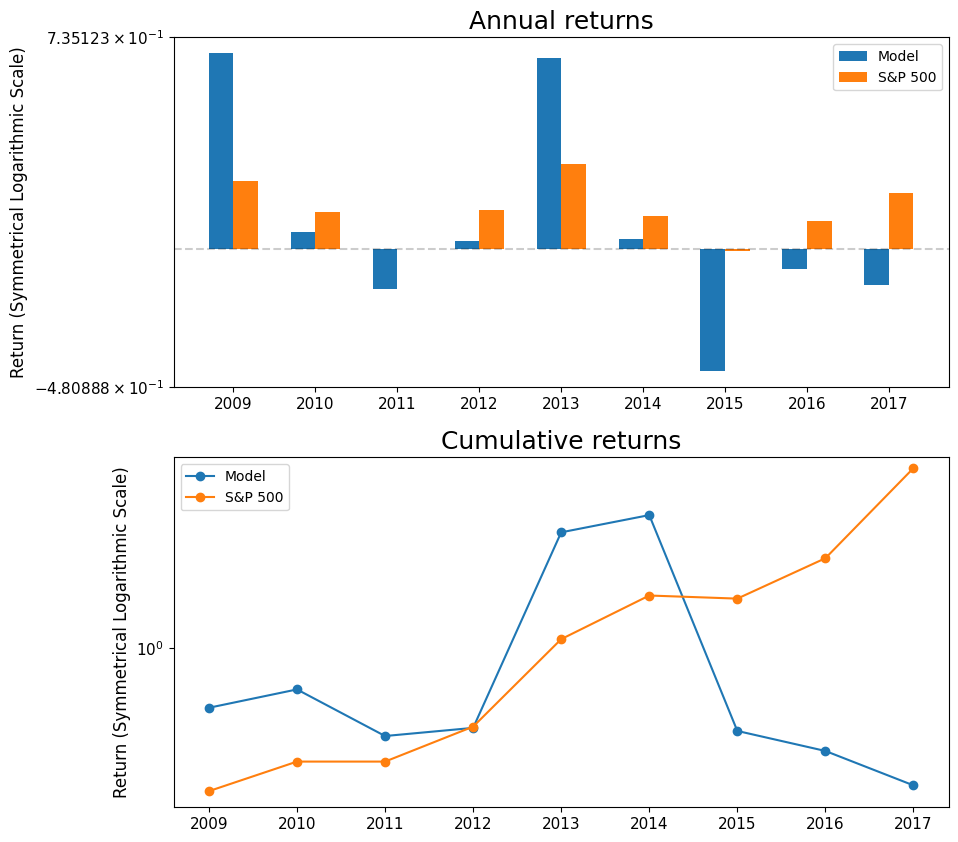

In [45]:
# Here, the monthly portfolio is composed of the top 20 best performing stocks
# of the previous month.
calculate_and_display_model_returns(20, 1, validation = False)

,model_annual_returns,sp500_annual_returns
year,,
2009,35.48%,23.45%
2010,18.82%,12.78%
2011,-20.26%,-0.00%
2012,2.23%,13.41%
2013,61.25%,29.60%
2014,111.34%,11.39%
2015,113.20%,-0.73%
2016,135.28%,9.54%
2017,44.07%,19.42%


,model_cumulative_returns,sp500_cumulative_returns
2009,35.48%,23.45%
2010,60.98%,39.23%
2011,28.37%,39.23%
2012,31.24%,57.90%
2013,111.62%,104.63%
2014,347.24%,127.94%
2015,853.51%,126.29%
2016,"2,143.41%",147.86%
2017,"3,132.09%",196.00%


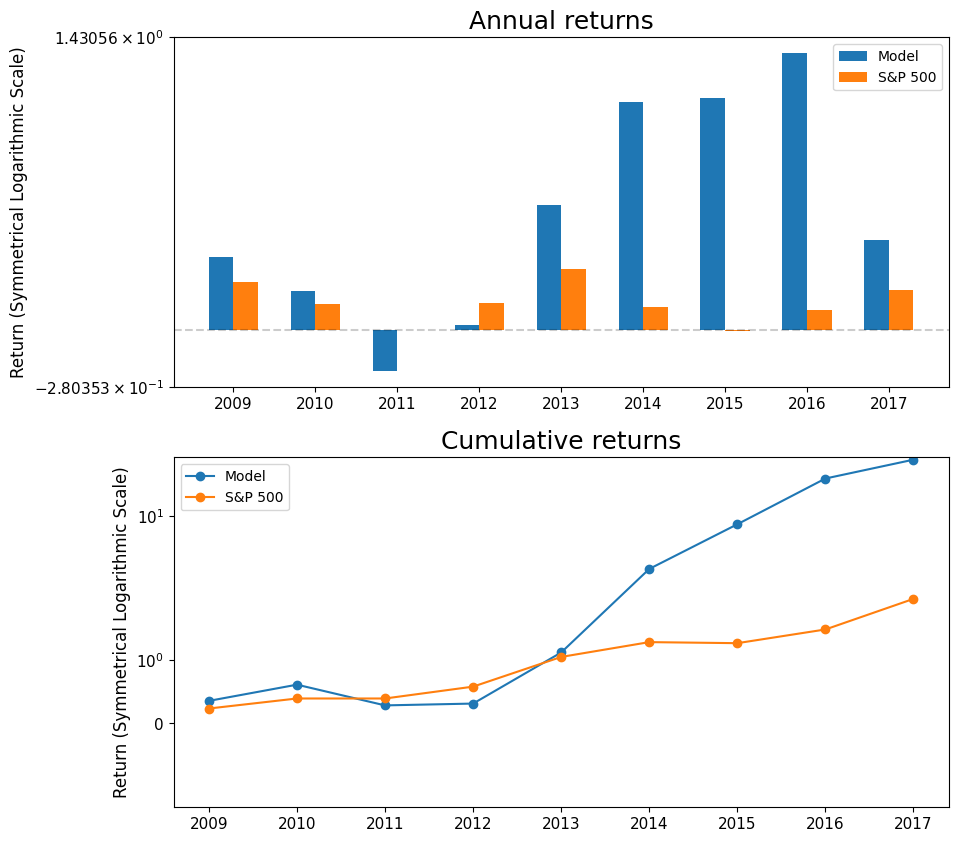

In [46]:
# Here, the monthly portfolio is composed of the top 20 best performing stocks
# of the previous 2 months.
calculate_and_display_model_returns(20, 2, validation = False)

,model_annual_returns,sp500_annual_returns
year,,
2009,53.60%,23.45%
2010,23.33%,12.78%
2011,-17.21%,-0.00%
2012,11.28%,13.41%
2013,85.99%,29.60%
2014,38.71%,11.39%
2015,21.48%,-0.73%
2016,-4.16%,9.54%
2017,3.80%,19.42%


,model_cumulative_returns,sp500_cumulative_returns
2009,53.60%,23.45%
2010,89.44%,39.23%
2011,56.83%,39.23%
2012,74.52%,57.90%
2013,224.59%,104.63%
2014,350.22%,127.94%
2015,446.92%,126.29%
2016,424.19%,147.86%
2017,444.10%,196.00%


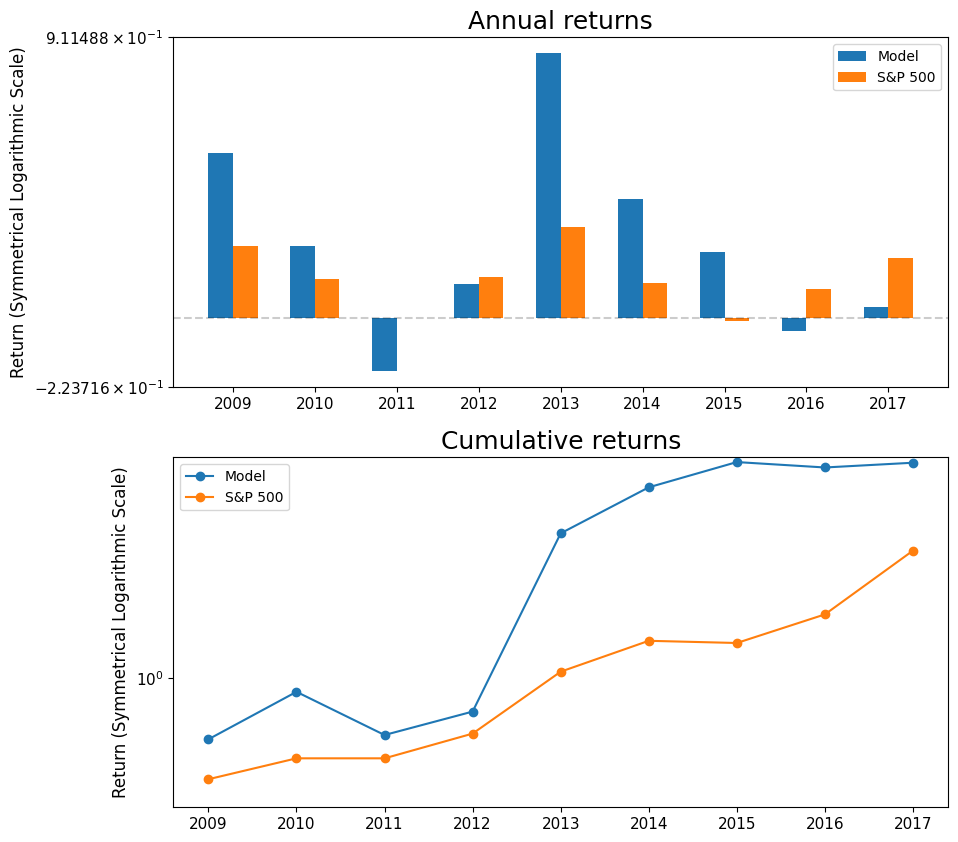

In [47]:
# Here, the monthly portfolio is composed of the top 20 best performing stocks
# of the previous 4 months.
calculate_and_display_model_returns(20, 4, validation = False)

,model_annual_returns,sp500_annual_returns
year,,
2009,15.49%,23.45%
2010,35.04%,12.78%
2011,-11.51%,-0.00%
2012,27.91%,13.41%
2013,103.34%,29.60%
2014,73.00%,11.39%
2015,111.81%,-0.73%
2016,15.29%,9.54%
2017,2.55%,19.42%


,model_cumulative_returns,sp500_cumulative_returns
2009,15.49%,23.45%
2010,55.96%,39.23%
2011,38.01%,39.23%
2012,76.53%,57.90%
2013,258.96%,104.63%
2014,520.99%,127.94%
2015,"1,215.29%",126.29%
2016,"1,416.37%",147.86%
2017,"1,455.02%",196.00%


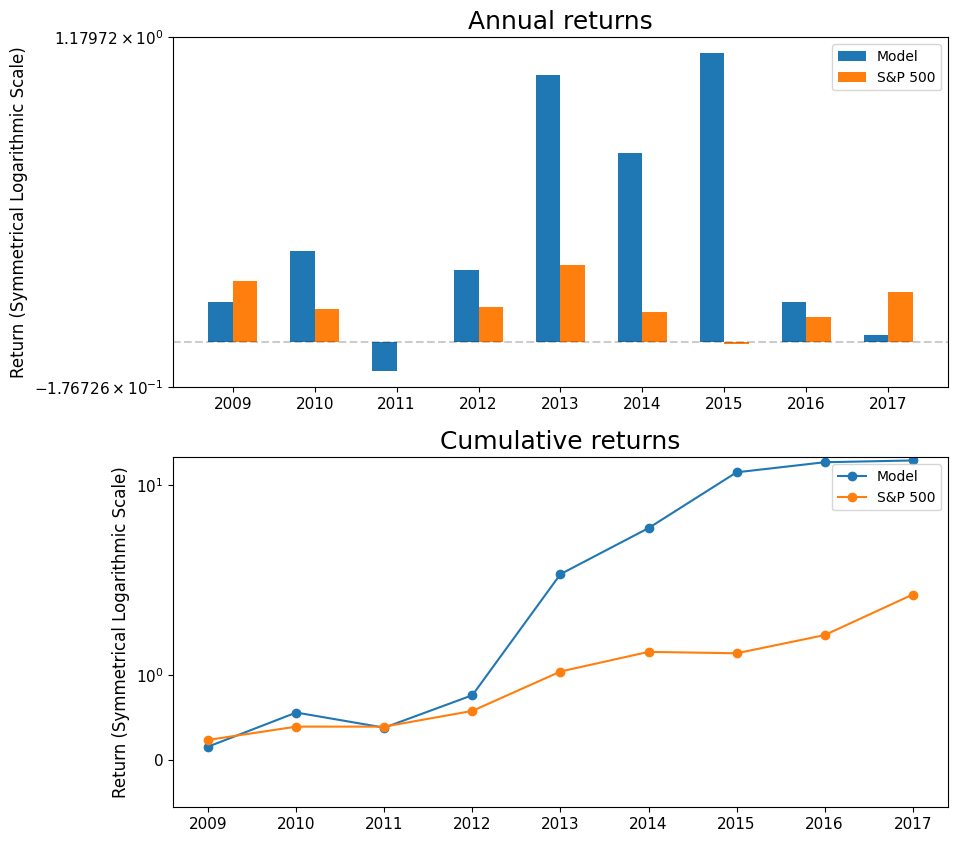

In [48]:
# Here, the monthly portfolio is composed of the top 20 best performing stocks
# of the previous 6 months.
calculate_and_display_model_returns(20, 6, validation = False)

,model_annual_returns,sp500_annual_returns
year,,
2009,11.90%,23.45%
2010,53.91%,12.78%
2011,-8.77%,-0.00%
2012,33.20%,13.41%
2013,107.06%,29.60%
2014,49.70%,11.39%
2015,32.52%,-0.73%
2016,17.51%,9.54%
2017,18.43%,19.42%


,model_cumulative_returns,sp500_cumulative_returns
2009,11.90%,23.45%
2010,72.21%,39.23%
2011,57.11%,39.23%
2012,109.27%,57.90%
2013,333.32%,104.63%
2014,548.65%,127.94%
2015,759.60%,126.29%
2016,910.14%,147.86%
2017,"1,096.33%",196.00%


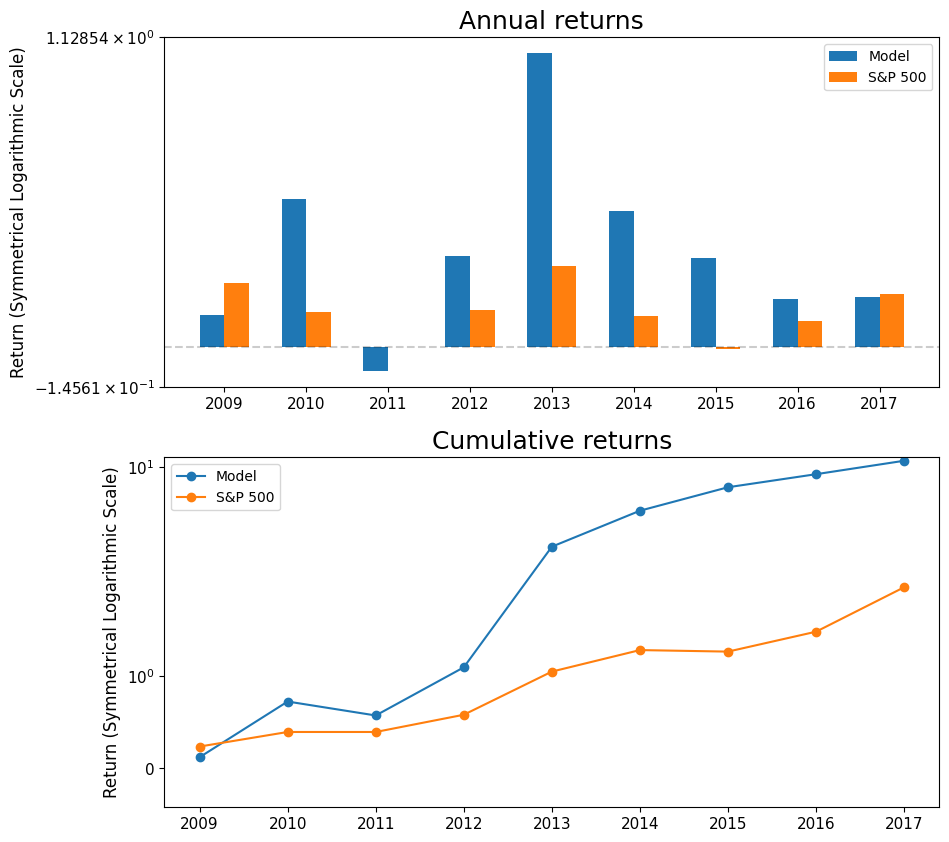

In [49]:
# Here, the monthly portfolio is composed of the top 20 best performing stocks
# of the previous 8 months.
calculate_and_display_model_returns(20, 8, validation = False)

,model_annual_returns,sp500_annual_returns
year,,
2009,2.25%,23.45%
2010,31.56%,12.78%
2011,-3.74%,-0.00%
2012,11.00%,13.41%
2013,95.47%,29.60%
2014,54.32%,11.39%
2015,161.05%,-0.73%
2016,254.22%,9.54%
2017,6.77%,19.42%


,model_cumulative_returns,sp500_cumulative_returns
2009,2.25%,23.45%
2010,34.52%,39.23%
2011,29.49%,39.23%
2012,43.74%,57.90%
2013,180.97%,104.63%
2014,333.59%,127.94%
2015,"1,031.91%",126.29%
2016,"3,909.40%",147.86%
2017,"4,180.72%",196.00%


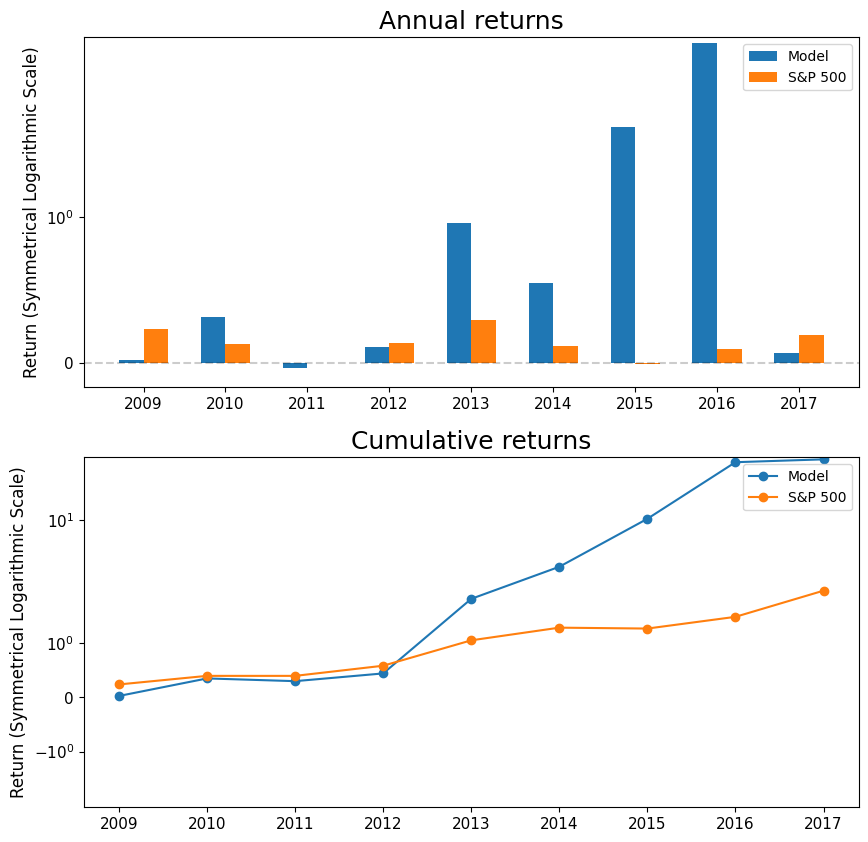

In [50]:
# Here, the monthly portfolio is composed of the top 20 best performing stocks
# of the previous 10 months.
calculate_and_display_model_returns(20, 10, validation = False)

,model_annual_returns,sp500_annual_returns
year,,
2009,18.55%,23.45%
2010,333.45%,12.78%
2011,-2.32%,-0.00%
2012,35.16%,13.41%
2013,74.84%,29.60%
2014,46.41%,11.39%
2015,157.70%,-0.73%
2016,175.49%,9.54%
2017,10.49%,19.42%


,model_cumulative_returns,sp500_cumulative_returns
2009,18.55%,23.45%
2010,413.87%,39.23%
2011,401.92%,39.23%
2012,578.38%,57.90%
2013,"1,086.10%",104.63%
2014,"1,636.61%",127.94%
2015,"4,375.22%",126.29%
2016,"12,228.67%",147.86%
2017,"13,521.60%",196.00%


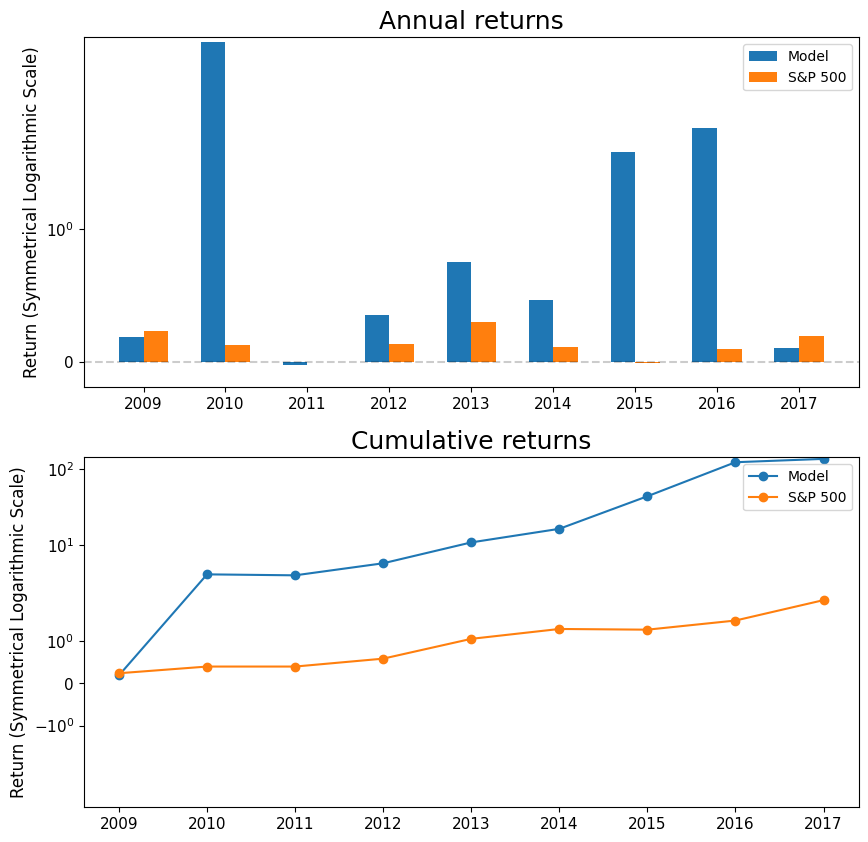

In [51]:
# Here, the monthly portfolio is composed of the top 20 best performing stocks
# of the previous 12 months.
calculate_and_display_model_returns(20, 12, validation = False)

,model_annual_returns,sp500_annual_returns
year,,
2009,16.96%,23.45%
2010,260.13%,12.78%
2011,-10.43%,-0.00%
2012,19.65%,13.41%
2013,72.77%,29.60%
2014,43.35%,11.39%
2015,105.75%,-0.73%
2016,-29.40%,9.54%
2017,4.79%,19.42%


,model_cumulative_returns,sp500_cumulative_returns
2009,16.96%,23.45%
2010,321.21%,39.23%
2011,277.28%,39.23%
2012,351.44%,57.90%
2013,679.94%,104.63%
2014,"1,018.07%",127.94%
2015,"2,200.42%",126.29%
2016,"1,524.21%",147.86%
2017,"1,601.97%",196.00%


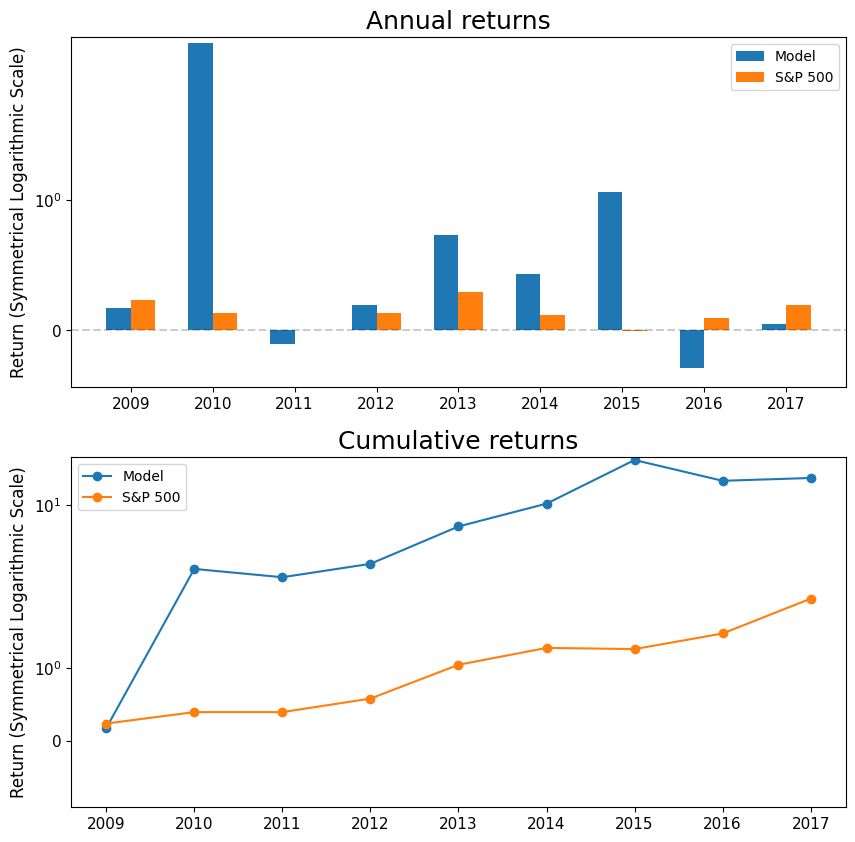

In [52]:
# Here, the monthly portfolio is composed of the top 20 best performing stocks
# of the previous 14 months.
calculate_and_display_model_returns(20, 14, validation = False)

Using the returns relative to 12 months in the past to calculate the monthly portfolio seems to give the best results, at least according to my training data here. So I will stick with this value for the next tests.

I will now experiment to increase or decrease the number of stocks in the portfolio.

,model_annual_returns,sp500_annual_returns
year,,
2009,15.61%,23.45%
2010,268.30%,12.78%
2011,-2.82%,-0.00%
2012,31.65%,13.41%
2013,58.86%,29.60%
2014,38.56%,11.39%
2015,107.78%,-0.73%
2016,149.07%,9.54%
2017,19.76%,19.42%


,model_cumulative_returns,sp500_cumulative_returns
2009,15.61%,23.45%
2010,325.79%,39.23%
2011,313.78%,39.23%
2012,444.77%,57.90%
2013,765.43%,104.63%
2014,"1,099.15%",127.94%
2015,"2,391.57%",126.29%
2016,"6,105.77%",147.86%
2017,"7,332.30%",196.00%


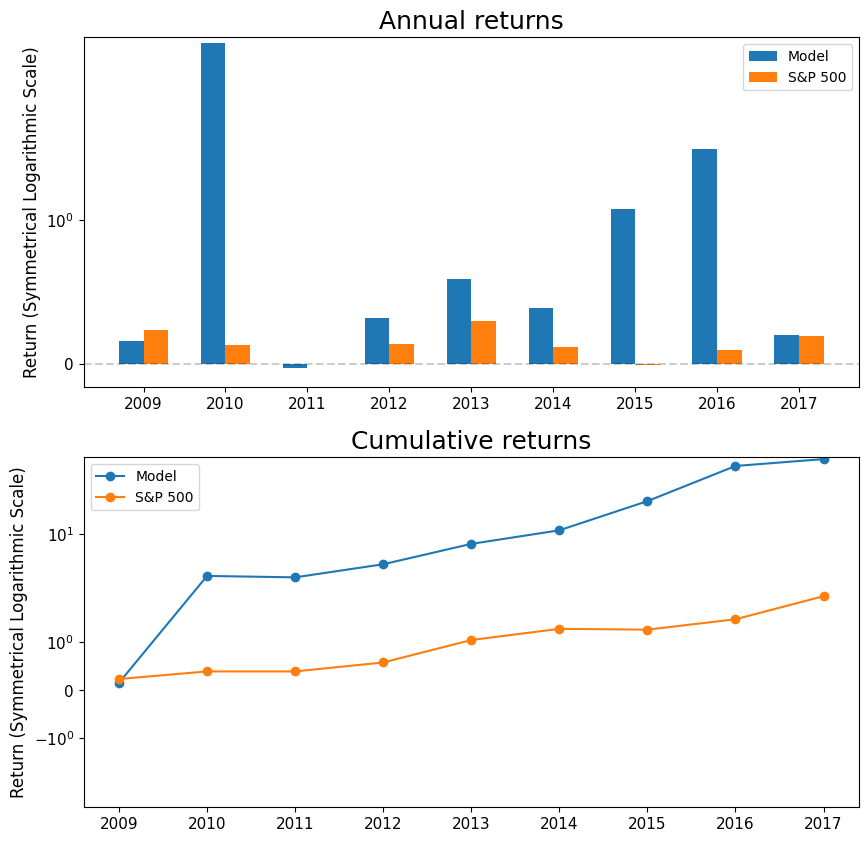

In [53]:
# Here, the monthly portfolio is composed of the top 25 best performing stocks
# of the previous 12 months.
calculate_and_display_model_returns(25, 12, validation = False)

Increasing from 20 to 25 stocks in the portfolio decreased significantly the final cumulative returns at the end of 2017 (using 12 months time period), so I will try decreasing the number of stocks in the portfolio

,model_annual_returns,sp500_annual_returns
year,,
2009,14.75%,23.45%
2010,444.64%,12.78%
2011,-5.85%,-0.00%
2012,36.00%,13.41%
2013,87.70%,29.60%
2014,55.22%,11.39%
2015,244.61%,-0.73%
2016,230.81%,9.54%
2017,5.23%,19.42%


,model_cumulative_returns,sp500_cumulative_returns
2009,14.75%,23.45%
2010,524.98%,39.23%
2011,488.40%,39.23%
2012,700.24%,57.90%
2013,"1,402.06%",104.63%
2014,"2,231.56%",127.94%
2015,"7,934.75%",126.29%
2016,"26,479.71%",147.86%
2017,"27,870.35%",196.00%


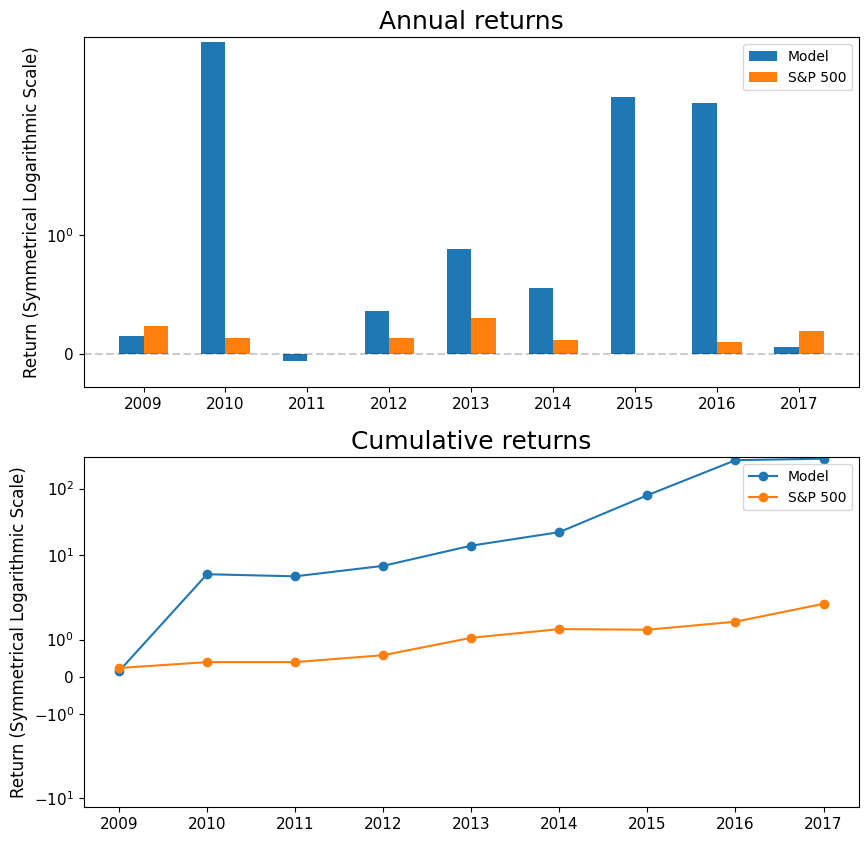

In [54]:
# Here, the monthly portfolio is composed of the top 15 best performing stocks
# of the previous 12 months.
calculate_and_display_model_returns(15, 12, validation = False)

,model_annual_returns,sp500_annual_returns
year,,
2009,26.06%,23.45%
2010,595.59%,12.78%
2011,-13.86%,-0.00%
2012,38.56%,13.41%
2013,97.74%,29.60%
2014,80.30%,11.39%
2015,375.30%,-0.73%
2016,328.08%,9.54%
2017,-11.32%,19.42%


,model_cumulative_returns,sp500_cumulative_returns
2009,26.06%,23.45%
2010,776.84%,39.23%
2011,655.34%,39.23%
2012,946.57%,57.90%
2013,"1,969.53%",104.63%
2014,"3,631.42%",127.94%
2015,"17,635.57%",126.29%
2016,"75,822.38%",147.86%
2017,"67,225.08%",196.00%


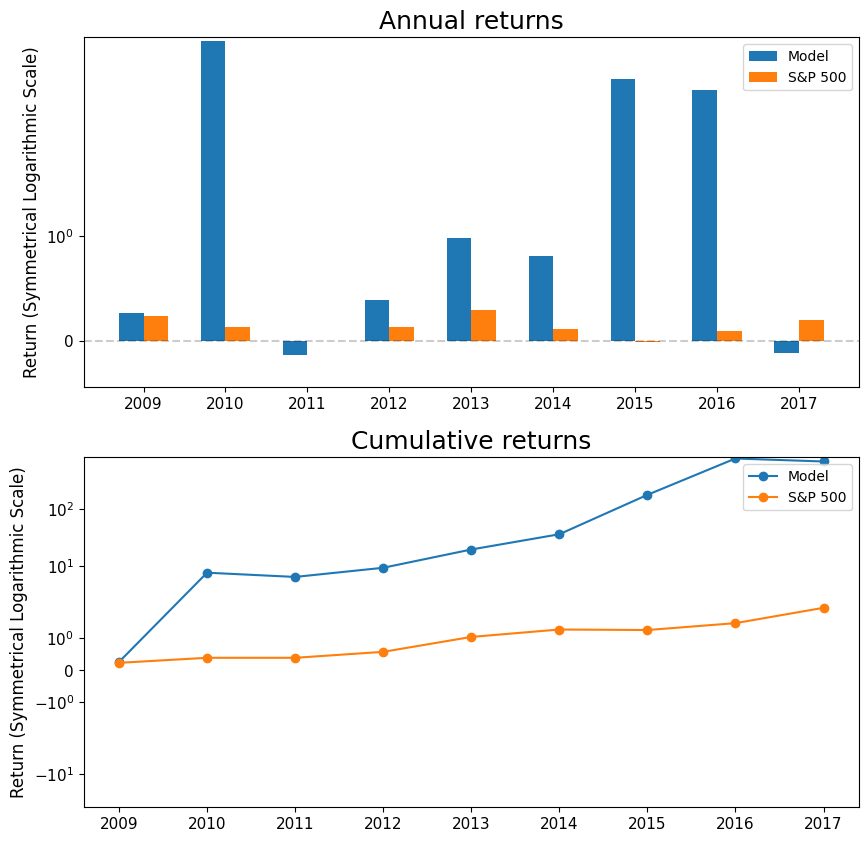

In [55]:
# Here, the monthly portfolio is composed of the top 10 best performing stocks
# of the previous 12 months.
calculate_and_display_model_returns(10, 12, validation = False)

,model_annual_returns,sp500_annual_returns
year,,
2009,5.50%,23.45%
2010,978.92%,12.78%
2011,-26.89%,-0.00%
2012,1.61%,13.41%
2013,144.68%,29.60%
2014,156.97%,11.39%
2015,878.39%,-0.73%
2016,398.77%,9.54%
2017,-26.94%,19.42%


,model_cumulative_returns,sp500_cumulative_returns
2009,5.50%,23.45%
2010,"1,038.28%",39.23%
2011,732.20%,39.23%
2012,745.58%,57.90%
2013,"1,968.95%",104.63%
2014,"5,216.59%",127.94%
2015,"51,916.87%",126.29%
2016,"259,344.57%",147.86%
2017,"189,458.40%",196.00%


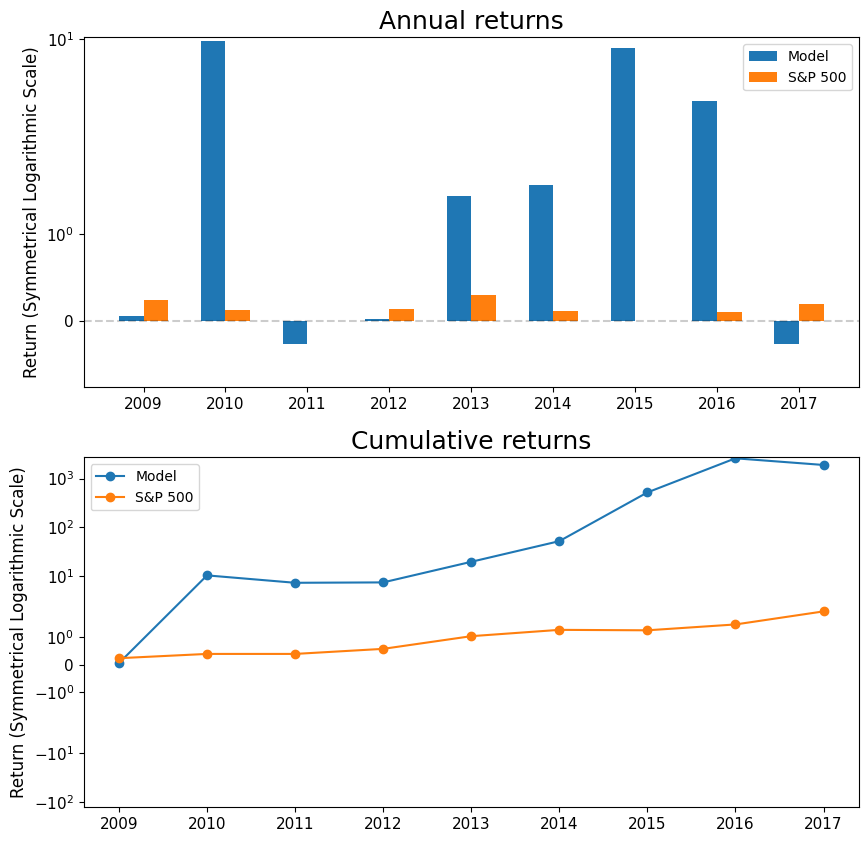

In [56]:
# Here, the monthly portfolio is composed of the top 5 best performing stocks
# of the previous 12 months.
calculate_and_display_model_returns(5, 12, validation = False)

Since this last model had the best cumulative returns at the end of the training dataset, I will choose it as the final model to be tested against the validation dataset

## 8. Testing the final model against the validation dataset

The best results (with the training data) were achieved by having a monthly portfolio composed by the top 5 best performing stocks of 12 months in the past. I will now run this model on the validation dataset. The returns of this model in the validation dataset (from 2018-01-01 to 2022-12-31) should also be higher than the S&P 500 returns (considering the accumulated returns), otherwise, it would be a useless model.

,model_annual_returns,sp500_annual_returns
year,,
2018,7.74%,-6.24%
2019,71.53%,28.88%
2020,296.55%,16.26%
2021,16.48%,26.89%
2022,51.68%,-20.89%


,model_cumulative_returns,sp500_cumulative_returns
2018,7.74%,-6.24%
2019,84.81%,20.84%
2020,632.85%,40.49%
2021,753.61%,78.27%
2022,"1,194.78%",41.03%


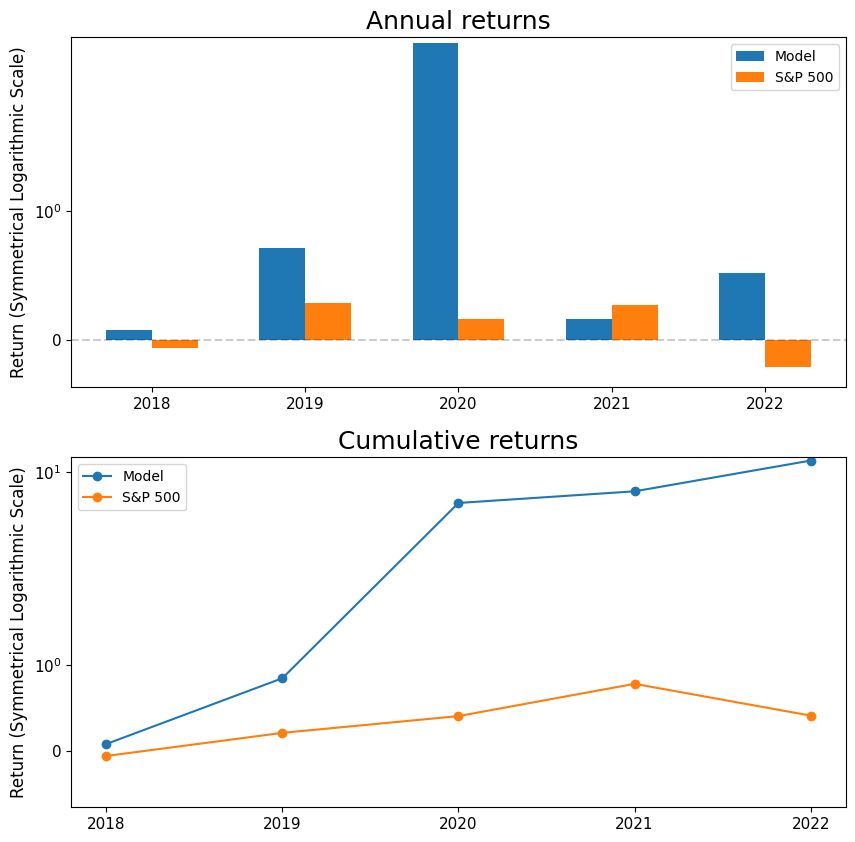

In [57]:
# Here, the monthly portfolio is composed of the top 5 best performing stocks
# of the previous 12 months
# This is the final model tested against the validation dataset
calculate_and_display_model_returns(5, 12, validation = True)

## 9. Conclusion

Notice that using the validation dataset, the final model (the last one shown) performs **better** than the S&P 500 index **in 4 out of 5 years**, and considering **accumulated returns**, it performs **better** than S&P 500 **in all 5 years**. The model's accumulated returns at the end of the validation dataset time period are **much higher** than the S&P 500 ones. 

The model seems to be able to beat the S&P 500 "in the long run" by yielding better returns during bull markets (in general). But it does not guarantee protection from bear markets, in fact during some specific months / years it may produce negative returns, worse than the S&P 500 returns (see the years of 2011 and 2017 during the 2 last tests in the training phase). This suggests following this model is a **riskier** investment strategy than simply buying and holding an ETF than replicates the S&P 500.

I have to remind you that **no** taxes or fees are taken into account in this study, and because of that alone, a real life investment strategy based on this final model would have yielded lower returns than what this theoretical study suggests. How much lower vastly depends on where you live, what services you use, etc. So there is no point for me to try to estimate it.

I also have to remind you that good past results are **NOT** a guarantee for good future results in any way, and that this whole study is just educational content, and not financial advise in any way. I am **NOT** responsible for any investing decision(s) you take. Thanks for reading.